# General Tips on Prompting

Before we get into some big applications of schema engineering I want to equip you with the tools for success. 

This notebook is to share some general advice when using prompts to get the most of your models. 

## Classification

For classification we've found theres generally two methods of modeling.

1. using Enums
2. using Literals


Use an enum in Python when you need a set of named constants that are related and you want to ensure type safety, readability, and prevent invalid values. Enums are helpful for grouping and iterating over these constants.

Use literals when you have a small, unchanging set of values that you don't need to group or iterate over, and when type safety and preventing invalid values is less of a concern. Literals are simpler and more direct for basic, one-off values.

In [9]:
from enum import Enum
from pydantic import BaseModel,Field
from typing import List,Literal
import instructor
from openai import OpenAI

client = instructor.patch(OpenAI())

# Tip: Do not use auto() as they cast to 1,2,3,4 
class House(Enum):
    Gryffindor = "gryffindor"
    Hufflepuff = "hufflepuff"
    Ravenclaw = "ravenclaw"
    Slytherin = "slytherin"

class Character(BaseModel):
    age: int
    name: str
    house: House
    
resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "Harry Potter"
        }
    ],
    response_model=Character
)
resp.model_dump()

{'age': 17, 'name': 'Harry Potter', 'house': <House.Gryffindor: 'gryffindor'>}

In [10]:
class Character(BaseModel):
    age: int
    name: str
    house: Literal["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
    
resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "Harry Potter"
        }
    ],
    response_model=Character
)
resp.model_dump()

{'age': 17, 'name': 'Harry Potter', 'house': 'Gryffindor'}

## Arbitrary long properties

Often times there are long properties that you might want to extract from data that we can not specify in advanced. We can get around this by defining an arbitrary key value store like so:

In [4]:
from typing import List

class Property(BaseModel):
    key: str = Field(description="Must be snake case")
    value: str

class Character(BaseModel):
    age: int
    name: str
    house: Literal["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
    properties: List[Property]

resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "Snape from Harry Potter"
        }
    ],
    response_model=Character
)
resp.model_dump()

{'age': 38,
 'name': 'Severus Snape',
 'house': 'Slytherin',
 'properties': [{'key': 'role', 'value': 'Professor of Potions'},
  {'key': 'loyalty', 'value': 'Dumbledore'},
  {'key': 'patronus', 'value': 'Doe'},
  {'key': 'played_by', 'value': 'Alan Rickman'}]}

## Limiting the length of lists 

In later chapters we'll talk about how to use validators to assert the length of lists but we can also use prompting tricks to enumerate values. Here we'll define a index to count the properties.

In this following example instead of extraction we're going to work on generation instead.

In [5]:
class Property(BaseModel):
    index: str = Field(..., description="Monotonically increasing ID")
    key: str
    value: str

class Character(BaseModel):
    age: int
    name: str
    house: Literal["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
    properties: List[Property] = Field(..., description="Numbered list of arbitrary extracted properties, should be exactly 5")

resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "Snape from Harry Potter"
        }
    ],
    response_model=Character
)
resp.model_dump()

{'age': 38,
 'name': 'Severus Snape',
 'house': 'Slytherin',
 'properties': [{'index': '1',
   'key': 'Occupation',
   'value': 'Potions Master, Defense Against the Dark Arts Professor, Headmaster'},
  {'index': '2',
   'key': 'Loyalty',
   'value': 'Hogwarts, Order of the Phoenix, Albus Dumbledore, Lily Potter'},
  {'index': '3',
   'key': 'Skills',
   'value': 'Potions, Occlumency, Legilimency, Spell creation'},
  {'index': '4', 'key': 'Patronus', 'value': 'Doe'},
  {'index': '5', 'key': 'Actor', 'value': 'Alan Rickman'}]}

## Defining Multiple Entities

Now that we see a single entity with many properties we can continue to nest them into many users

In [6]:
class Characters(BaseModel):
    users: List[Character]

resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "Snape and Dumbledore from Harry Potter"
        }
    ],
    response_model=Characters
)
resp.model_dump()

{'users': [{'age': 38,
   'name': 'Severus Snape',
   'house': 'Slytherin',
   'properties': [{'index': '1',
     'key': 'Occupation',
     'value': 'Potions Master, Defense Against the Dark Arts teacher, Headmaster'},
    {'index': '2',
     'key': 'Loyalty',
     'value': 'Hogwarts School, Order of the Phoenix, Albus Dumbledore'},
    {'index': '3',
     'key': 'Skills',
     'value': 'Potions, Occlumency, Legilimency'},
    {'index': '4', 'key': 'Patronus', 'value': 'Doe'},
    {'index': '5', 'key': 'Played by', 'value': 'Alan Rickman'}]},
  {'age': 115,
   'name': 'Albus Dumbledore',
   'house': 'Gryffindor',
   'properties': [{'index': '1',
     'key': 'Occupation',
     'value': 'Headmaster, Founder of the Order of the Phoenix'},
    {'index': '2',
     'key': 'Loyalty',
     'value': 'Hogwarts School, Order of the Phoenix'},
    {'index': '3', 'key': 'Skills', 'value': 'Transfiguration, Alchemy'},
    {'index': '4', 'key': 'Patronus', 'value': 'Phoenix'},
    {'index': '5',
    

## Defining Relationships 

Now only can we define lists of users, with list of properties one of the more interesting things I've learned about prompting is that we can also easily define lists of references.

In [7]:
class Character(BaseModel):
    id: int
    name: str
    friends: List[int]

class Characters(BaseModel):
    users: List[Character]

resp = client.chat.completions.create(
    model="gpt-4-1106-preview",
    messages=[
        {
            "role": "user", 
            "content": "The kids from from Harry Potter"
        }
    ],
    response_model=Characters
)
resp.model_dump()

{'users': [{'id': 1, 'name': 'Harry Potter', 'friends': [2, 3, 4, 5, 6, 7]},
  {'id': 2, 'name': 'Ron Weasley', 'friends': [1, 3, 5, 6, 7]},
  {'id': 3, 'name': 'Hermione Granger', 'friends': [1, 2, 5, 6, 7]},
  {'id': 4, 'name': 'Draco Malfoy', 'friends': [1, 7]},
  {'id': 5, 'name': 'Neville Longbottom', 'friends': [1, 2, 3]},
  {'id': 6, 'name': 'Luna Lovegood', 'friends': [1, 2, 3]},
  {'id': 7, 'name': 'Ginny Weasley', 'friends': [1, 2, 3]},
  {'id': 8, 'name': 'Fred Weasley', 'friends': [2, 7]},
  {'id': 9, 'name': 'George Weasley', 'friends': [2, 7]}]}

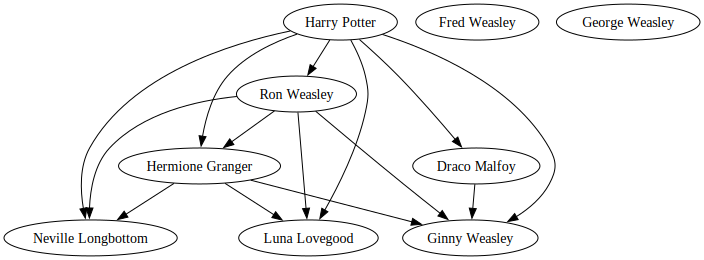

In [8]:
from graphviz import Digraph
from IPython.display import display
from typing import List

dot = Digraph()

# Create nodes for each user
for user in resp.users:
    dot.node(str(user.id), user.name)

# Create edges for friends
for user in resp.users:
    for friend_id in user.friends:
        # To avoid duplicating edges, only add an edge if the friend ID is greater than the user ID
        if friend_id > user.id:
            dot.edge(str(user.id), str(friend_id))
            

# Render the graph to a file
display(dot)

With the tools we've discussed, we can find numerous real-world applications in production settings. These include extracting action items from transcripts, generating fake data, filling out forms, and creating objects that correspond to generative UI. These simple tricks will be highly useful.